<a href="https://colab.research.google.com/github/MOISECHRIST/Tensorflow_DeepLearn_Course/blob/main/Recreer_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreer Tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Creation des boites pour les différentes opéralitions de chaque couche

### Boite Générique

In [2]:
class BoxGeneric:
  def __init__(self):
    pass

  def forward(self, imputs):
    self.imputs = imputs
    self.output = self.compute()
    return self.output

  def backward(self, derivee_output):
    assert self.output.shape == derivee_output.shape, f"La dérivee de l'output a un shape {derivee_output.shape} différent de ce celui de output {self.output.shape}"
    self.derivee_output = derivee_output

    self.derivee_input = self.compute_gradient()
    return self.derivee_input

  def compute(self):
    pass

  def compute_gradient(self):
    pass

### Boite Avec Parametre

In [3]:
class BoxParams(BoxGeneric):
  def __init__(self, params):
    super().__init__()
    self.params = params

  def backward(self, derivee_output):
    assert self.output.shape == derivee_output.shape, f"La dérivee de l'output a un shape {derivee_output.shape} différent de ce celui de output {self.output.shape}"
    self.derivee_output = derivee_output

    self.derivee_input = self.compute_gradient()
    self.derivee_params = self.compute_gradient_params()

    assert self.params.shape == self.derivee_params.shape, f"La dérivee des parametres a un shape {self.derivee_params.shape} différent de ce celui des parametres {self.params.shape}"
    assert self.derivee_input.shape == self.imputs.shape, f"La dérivee des imputs calculee a un shape {self.derivee_input.shape} différent de ce celui des parametres {self.imputs.shape}"

    return self.derivee_input

  def update_params(self, lr = 0.001):
    self.params=self.params - lr*self.derivee_params

  def compute_gradient_params(self):
    pass

#### Opération Produit Matriciel W*X

In [4]:
class BoxDotOperation(BoxParams):
  def __init__(self, weight):
    super().__init__(weight)

  def compute(self):
    return np.dot(self.imputs, self.params)

  def compute_gradient(self):
    return np.dot(self.derivee_output, self.params.T)

  def compute_gradient_params(self):
    return np.dot(self.imputs.T, self.derivee_output)

  def __repr__(self):
    return "DotOperation"

On teste la classe `BoxDotOperation`

In [5]:
X=np.array([[2,3,-2],
            [4,5,-1],
            [5,2,3],
            [0,5,4]])

In [6]:
X.shape

(4, 3)

In [7]:
W=np.array([[0.49671415],
            [-0.1382643],
            [0.64768854]])

In [8]:
W.shape

(3, 1)

In [9]:
np.dot(X,W)

array([[-0.71674168],
       [ 0.64784656],
       [ 4.15010777],
       [ 1.89943266]])

In [10]:
M = BoxDotOperation(W)
out_dot=M.forward(X)

In [11]:
d_output = np.random.randn(4,1)
d_output

array([[-1.32393699],
       [ 0.19473151],
       [ 2.18438485],
       [-0.48897022]])

In [12]:
M.backward(d_output)

array([[-0.65761824,  0.18305322, -0.85749882],
       [ 0.0967259 , -0.02692442,  0.12612537],
       [ 1.08501486, -0.30202244,  1.41480104],
       [-0.24287843,  0.06760713, -0.31670041]])

In [13]:
M.derivee_params.shape

(3, 1)

#### Opération Ajout du biais

In [14]:
class BoxAddBiasOperation(BoxParams):
  def __init__(self, bias):
    super().__init__(bias)

  def compute(self):
    return self.imputs + self.params

  def compute_gradient(self):
    return np.ones_like(self.imputs) * self.derivee_output

  def compute_gradient_params(self):
    return (np.ones_like(self.imputs) * self.derivee_output).sum(axis=0).reshape(1,-1)

  def __repr__(self):
    return "AddBiasOperation"

On teste la classe `BoxAddBiasOperation`

In [15]:
B = np.random.rand(1,1)
B

array([[0.1834024]])

In [16]:
b = BoxAddBiasOperation(B)
b.forward(out_dot)

array([[-0.53333928],
       [ 0.83124896],
       [ 4.33351017],
       [ 2.08283506]])

In [17]:
out_b=b.backward(d_output)

### Opération Non paramétriques

#### Sigmoid

In [18]:
class Sigmoid(BoxGeneric):
  def __init__(self):
    super().__init__()

  def compute(self):
    return 1/(1+np.exp(-self.imputs))

  def compute_gradient(self):
    return self.output * (1-self.output) * self.derivee_output

  def __repr__(self):
    return "Sigmoid"

In [19]:
f=Sigmoid()
f.forward(out_b)

array([[0.21016403],
       [0.54852962],
       [0.89883848],
       [0.38013619]])

In [20]:
y_hat = f.backward(d_output)

#### Tanh

In [21]:
class Tanh(BoxGeneric):
  def __init__(self):
    super().__init__()

  def compute(self):
    return np.tanh(self.imputs)

  def compute_gradient(self):
    return 1 - np.tanh(self.imputs)**2 * self.derivee_output

  def __repr__(self):
    return "Tanh"

In [22]:
g=Tanh()
g.forward(out_b)

array([[-0.86775967],
       [ 0.19230685],
       [ 0.97498325],
       [-0.45339873]])

In [23]:
g.backward(d_output)

array([[ 1.99693361],
       [ 0.99279845],
       [-1.07645951],
       [ 1.10051781]])

#### Softmax

In [24]:
class Softmax(BoxGeneric):
  def __init__(self):
    super().__init__()

  def compute(self):
    tmp = np.sum(np.exp(self.imputs))
    return np.exp(self.imputs) / tmp

  def compute_gradient(self):
    return self.output * (1-self.output) * self.derivee_output

  def __repr__(self):
    return "Softmax"

In [25]:
h=Softmax()
h.forward(out_b)

array([[0.02423475],
       [0.11065929],
       [0.80925122],
       [0.05585474]])

In [26]:
h.backward(d_output)

array([[-0.0313077 ],
       [ 0.01916427],
       [ 0.33718969],
       [-0.02578584]])

#### Relu

In [27]:
class Relu(BoxGeneric):
  def __init__(self):
    super().__init__()

  def compute(self):
    return np.maximum(0, self.imputs)

  def compute_gradient(self):
    return (self.imputs > 0) * self.derivee_output

  def __repr__(self):
    return "Relu"

In [28]:
r = Relu()
r.forward(out_b)

array([[0.        ],
       [0.19473151],
       [2.18438485],
       [0.        ]])

In [29]:
r.backward(d_output)

array([[-0.        ],
       [ 0.19473151],
       [ 2.18438485],
       [-0.        ]])

#### Linéaire

In [30]:
class Linear(BoxGeneric):
  def __init__(self):
    super().__init__()

  def compute(self):
    return self.imputs

  def compute_gradient(self):
    return np.ones_like(self.imputs)* self.derivee_output

  def __repr__(self):
    return "Linear"

In [31]:
l=Linear()
l.forward(out_b)

array([[-1.32393699],
       [ 0.19473151],
       [ 2.18438485],
       [-0.48897022]])

In [32]:
l.backward(d_output)

array([[-1.32393699],
       [ 0.19473151],
       [ 2.18438485],
       [-0.48897022]])

### Calcul des erreurs

In [33]:
class LossBox(BoxGeneric):
  def __init__(self):
    super().__init__()

  def forward(self, predic, target):
    self.predic = predic
    self.target = target
    self.output = self.compute()
    return self.output

  def backward(self):
    self.derivee_input = self.compute_gradient()
    return self.derivee_input

#### MSE

In [34]:
class MSE(LossBox):
  def __init__(self):
    super().__init__()

  def compute(self):
    return np.mean((self.predic - self.target)**2)

  def compute_gradient(self):
    return 2 * (self.predic - self.target)

  def __repr__(self):
    return "MSE"

In [35]:
y=np.random.rand(4,1)
y

array([[0.81473189],
       [0.38836847],
       [0.72746554],
       [0.9855786 ]])

In [36]:
error = MSE()
error.forward(y_hat, y)

0.6693284957868754

In [37]:
error.backward()

array([[-2.06899791],
       [-0.68028843],
       [-1.05768815],
       [-2.20159192]])

#### RMSE

In [38]:
class RMSE(LossBox):
  def __init__(self):
    super().__init__()

  def compute(self):
    return np.sqrt(np.mean((self.predic - self.target)**2))

  def compute_gradient(self):
    return (self.predic - self.target) / self.output

  def __repr__(self):
    return "RMSE"

In [39]:
error = RMSE()
error.forward(y_hat, y)

0.8181249878758595

In [40]:
error.backward()

array([[-1.26447544],
       [-0.41576069],
       [-0.64640988],
       [-1.34551075]])

In [41]:
class MAE(LossBox):
  def __init__(self):
    super().__init__()

  def compute(self):
    return (np.mean(np.abs(self.predic - self.target)))

  def compute_gradient(self):
    return 1/len(self.predic) * np.sign(self.predic - self.target)

  def __repr__(self):
    return "MAE"

In [42]:
err=MAE()
err.forward(y_hat, y)

0.7510708018815659

In [43]:
err.backward()

array([[-0.25],
       [-0.25],
       [-0.25],
       [-0.25]])

## Creation des Couches du réseau

In [44]:
class Dense:
  def __init__(self, neurons : int, activation=Linear()):
    self.neurons = neurons
    self.activation = activation
    self.operations=[]
    self.initialisation=True
    self.imputs_size=None
    self.weights=None
    self.bias=None

  def builder(self, imputs_size : int, random_state=0):
    np.random.seed(random_state)
    self.imputs_size = imputs_size
    self.weights = np.random.randn(self.imputs_size, self.neurons)
    self.bias = np.random.randn(1, self.neurons)
    self.operations.append(BoxDotOperation(self.weights))
    self.operations.append(BoxAddBiasOperation(self.bias))
    self.operations.append(self.activation)

  def forward(self, imputs, random_state=0):

    if self.initialisation :
      self.builder(imputs.shape[1], random_state)
      self.initialisation=False

    tmp = imputs
    for operation in self.operations:
      tmp = operation.forward(tmp)

    self.output=tmp
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape==self.output.shape

    tmp = derivee_output
    for operation in reversed(self.operations):
      tmp = operation.backward(tmp)

    self.derivee_input=tmp
    return self.derivee_input

  def update_params(self, lr=0.001):
    for operation in self.operations:
      if isinstance(operation, BoxParams):
        operation.update_params(lr)

  def __repr__(self):
    return f"Dense(nerons={self.neurons}, activation={self.activation})"

In [45]:
couche = Dense(2, Sigmoid())

In [46]:
X.shape[1]

3

In [47]:
couche.forward(X)

array([[0.97538055, 0.99991095],
       [0.99998383, 0.9999988 ],
       [0.99999997, 0.9676852 ],
       [0.99999835, 0.99921103]])

In [48]:
for params in couche.operations:
  if isinstance(params, BoxParams):
    print(params.params)

[[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]]
[[ 0.95008842 -0.15135721]]


In [49]:
d_out = np.random.randn(4,2)
d_out

array([[-0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502],
       [ 0.44386323,  0.33367433]])

In [50]:
couche.backward(d_out)

array([[-4.35779956e-03, -2.34399682e-03, -4.66471291e-03],
       [ 4.80819828e-06,  6.19855804e-06,  2.64023033e-06],
       [ 1.52257601e-03,  8.52627300e-03, -3.71834838e-03],
       [ 1.06554315e-04,  5.90184734e-04, -2.55704407e-04]])

In [51]:
couche.update_params(lr=0.001)

In [52]:
for params in couche.operations:
  if isinstance(params, BoxParams):
    print(params.params)

[[ 1.76405729  0.4001381 ]
 [ 0.9787454   2.24088416]
 [ 1.86755303 -0.97729027]]
[[ 0.95009089 -0.15136131]]


## Classe pour le reseau de neurones

In [53]:
from copy import deepcopy
import pickle

In [54]:
class NeuralNetwork:

  def __init__(self, layers=[]):
    self.layers = layers
    self.loss = None
    self.history=[]

  def forward(self, inputs, random_state=0):
    tmp = inputs
    for layer in self.layers:
      tmp = layer.forward(tmp, random_state)
    self.output = tmp
    return self.output

  def backward(self, derivee_output):
    tmp = derivee_output
    for layer in reversed(self.layers):
      tmp = layer.backward(tmp)

    return tmp

  def update_params(self, lr=0.001):
    for layer in self.layers:
      layer.update_params(lr)


  def add(self, layer:Dense):
    self.layers.append(layer)

  def compile(self, loss=MSE()):
    self.loss = loss

  def print_train(self, loss_value, epoch, nb_epochs):
    print(f"Epoch {epoch}/{nb_epochs}\n [==============================] - loss: {loss_value:.2f}")
    self.history.append(loss_value)

  def fit(self, input_train, target_train, epochs : int, lr : float, random_state=0):
    for epoch in range(epochs):
      y_hat = self.forward(input_train, random_state)
      loss_value = self.loss.forward(y_hat, target_train)
      self.print_train(loss_value, epoch+1, epochs)
      i=np.random.randint(input_train.shape[0])
      #print(f"- Targe {i} : {target_train[i]}")
      #print(f"- Predict {i} : {y_hat[i]}")
      tmp = self.loss.backward()
      self.backward(tmp)
      self.update_params(lr)

  def predict(self, input_test):
    tmp = input_test
    for layer in self.layers:
      tmp = layer.forward(tmp)

    return tmp

  def save(self, path):
    model_save = deepcopy(self)
    with open(path, "wb") as f:
      pickle.dump(model_save, f)

  def __repr__(self):
    r="-"*40
    r += "\n"
    for layer in self.layers:
      r += f"{layer} \n"
    r += "-"*40
    return r

# Application avec Boston Dataset

In [55]:
import pandas as pd

In [56]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_data.values[::2, :], raw_data.values[1::2, :2]])
target = raw_data.values[1::2, 2]
target=target.reshape(-1,1)
raw_data=pd.DataFrame(data)
raw_data=raw_data.set_axis(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'], axis=1)
raw_data['MEDV']=target

In [57]:
raw_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [58]:
X=np.array(raw_data.drop('MEDV', axis=1))
y=np.array(raw_data['MEDV'])

In [59]:
y=y.reshape(-1,1)

In [60]:
X.shape, y.shape

((506, 13), (506, 1))

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [63]:
scalar=StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354, 1), (152, 1))

In [65]:
model_boston=NeuralNetwork()
model_boston.add(Dense(20, Sigmoid()))
model_boston.add(Dense(25, Sigmoid()))
model_boston.add(Dense(1))
model_boston.compile(MSE())

In [66]:
model_boston

----------------------------------------
Dense(nerons=20, activation=Sigmoid) 
Dense(nerons=25, activation=Sigmoid) 
Dense(nerons=1, activation=Linear) 
----------------------------------------

In [67]:
model_boston.fit(X_train, y_train, 100, 0.0001, random_state=0)

Epoch 1/100
 [==============================] - loss: 364.04
Epoch 2/100
 [==============================] - loss: 75.79
Epoch 3/100
 [==============================] - loss: 63.20
Epoch 4/100
 [==============================] - loss: 56.22
Epoch 5/100
 [==============================] - loss: 51.63
Epoch 6/100
 [==============================] - loss: 48.22
Epoch 7/100
 [==============================] - loss: 45.45
Epoch 8/100
 [==============================] - loss: 43.09
Epoch 9/100
 [==============================] - loss: 41.05
Epoch 10/100
 [==============================] - loss: 39.27
Epoch 11/100
 [==============================] - loss: 37.70
Epoch 12/100
 [==============================] - loss: 36.29
Epoch 13/100
 [==============================] - loss: 35.02
Epoch 14/100
 [==============================] - loss: 33.86
Epoch 15/100
 [==============================] - loss: 32.81
Epoch 16/100
 [==============================] - loss: 31.84
Epoch 17/100
 [=================

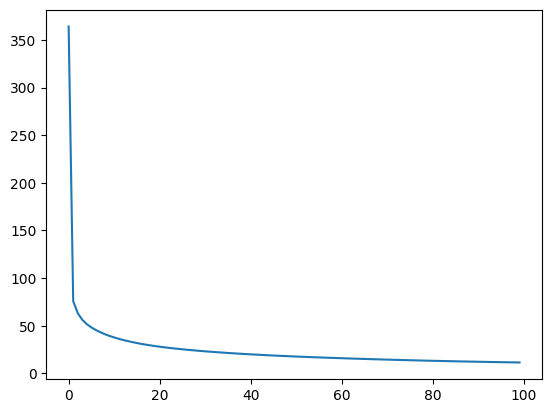

In [68]:
plt.plot(model_boston.history)

In [69]:
y_predict=model_boston.predict(X_test)

In [70]:
error=RMSE()
error.forward(y_predict, y_test), np.sqrt(model_boston.history[-1])

(4.715871333132779, 3.3832890057423275)

In [71]:
error=MAE()
error.forward(y_predict, y_test)

2.8753352941687673

In [72]:
i=np.random.randint(y_test.shape[0])
i, y_test[i,0], y_predict[i,0]

(67, 15.0, 18.445956407174776)

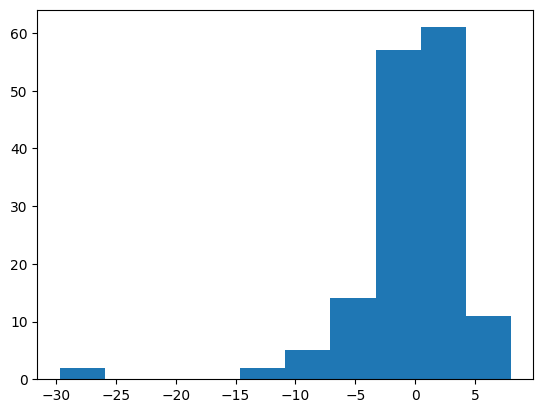

In [73]:
plt.hist((y_predict-y_test))
plt.show()

In [74]:
model_boston

----------------------------------------
Dense(nerons=20, activation=Sigmoid) 
Dense(nerons=25, activation=Sigmoid) 
Dense(nerons=1, activation=Linear) 
----------------------------------------

In [75]:
model_boston.save("model_boston.pkl")

In [76]:
def load_model(path):
  with open(path, "rb") as f:
    model = pickle.load(f)
  return model

In [77]:
model_loaded = load_model("model_boston.pkl")

In [78]:
model_loaded

----------------------------------------
Dense(nerons=20, activation=Sigmoid) 
Dense(nerons=25, activation=Sigmoid) 
Dense(nerons=1, activation=Linear) 
----------------------------------------

# Creer un modèle en utilisant Tensorflow

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [92]:
model = Sequential()
model.add(Dense(20, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 20)                  │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 831 (3.25 KB)

 Trainable params: 831 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(optimizer=SGD(learning_rate=0.01), loss='mse')

In [95]:
h = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 329.3225  
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.6455 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.6914 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.4052 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.3398 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.1367 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.5523  
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0534 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.6242 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.0864 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.9140 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6790 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.3181 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6541 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 

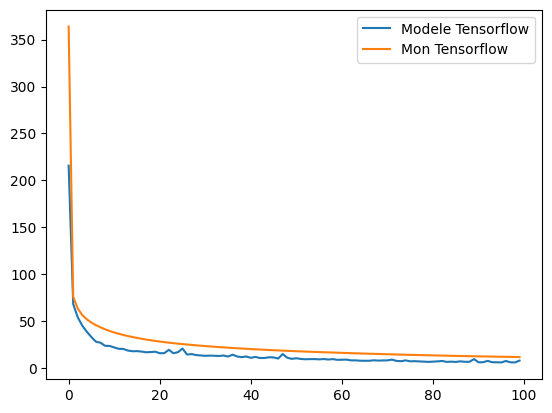

In [99]:
plt.plot(h.history['loss'], label='Modele Tensorflow')
plt.plot(model_boston.history, label = 'Mon Tensorflow')
plt.legend()
plt.show()

In [107]:
from joblib import dump, load

In [108]:
dump(scalar, 'scaler.joblib')
dump(model, 'model_boston.joblib')

['model_boston.joblib']

In [109]:
model_tf = load('model_boston.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [110]:
model_tf.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 20)                  │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,664 (6.50 KB)

 Trainable params: 831 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 833 (3.26 KB)